In [ ]:
pip install tensorflow matplotlib numpy kaggle


In [ ]:
from google.colab import files

# Upload the dataset
files.upload()  # Upload your 'monet_jpg.zip' file

# Unzip the uploaded dataset
!unzip /content/monet_jpg.zip -d /content/monet_jpg/


Saving monet_jpg.zip to monet_jpg (2).zip
Archive:  /content/monet_jpg.zip
  inflating: /content/monet_jpg/718445ebe3.jpg  
  inflating: /content/monet_jpg/09b76b6471.jpg  
  inflating: /content/monet_jpg/8114fa2607.jpg  
  inflating: /content/monet_jpg/1994b8d4a2.jpg  
  inflating: /content/monet_jpg/e9f686534b.jpg  
  inflating: /content/monet_jpg/429e382095.jpg  
  inflating: /content/monet_jpg/99d94af5dd.jpg  
  inflating: /content/monet_jpg/3deea9f4a4.jpg  
  inflating: /content/monet_jpg/dc33f0edbe.jpg  
  inflating: /content/monet_jpg/2f20944b6a.jpg  
  inflating: /content/monet_jpg/fb806a2a1c.jpg  
  inflating: /content/monet_jpg/252d9a4abc.jpg  
  inflating: /content/monet_jpg/2759c1ed37.jpg  
  inflating: /content/monet_jpg/fba982625d.jpg  
  inflating: /content/monet_jpg/118da0690c.jpg  
  inflating: /content/monet_jpg/ede9769cb3.jpg  
  inflating: /content/monet_jpg/c4622e3fb6.jpg  
  inflating: /content/monet_jpg/4995c04b1a.jpg  
  inflating: /content/monet_jpg/b1310da865.

Load and visualize images

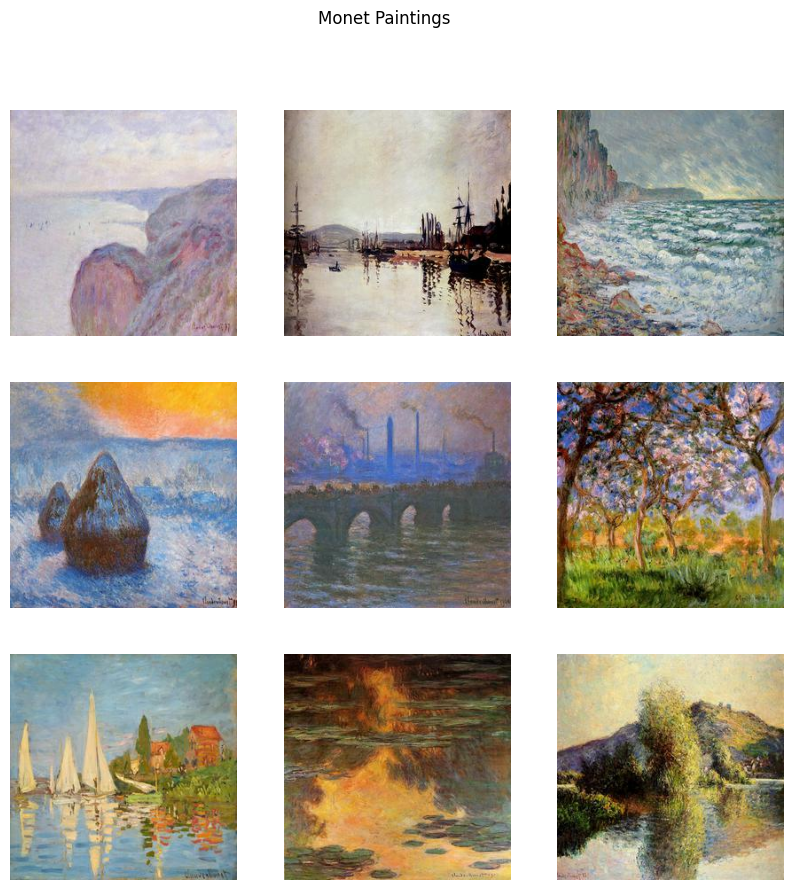

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set the path to the unzipped folder
monet_dir = '/content/monet_jpg/'

# Function to load images
def load_images(directory, size=(256, 256)):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = load_img(img_path, target_size=size)
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Load Monet images
monet_images = load_images(monet_dir)

# Visualize some Monet images
def plot_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.uint8(images[i]))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot sample Monet images
plot_images(monet_images, 'Monet Paintings')


In [ ]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma')

        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta')

        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (inputs - mean) * inv
        return self.gamma * normalized + self.beta


In [ ]:
# Remove the import for tensorflow_addons
# import tensorflow_addons as tfa  # Remove this line

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, ReLU, LeakyReLU, Activation
from tensorflow.keras.models import Model
# No need to import InstanceNormalization from tensorflow_addons
# from tensorflow_addons.layers import InstanceNormalization  # Remove this line


In [ ]:
# When defining res_block and models, use the custom InstanceNormalization

def res_block(x, filters, size=3):
    y = Conv2D(filters, size, padding='same')(x)
    y = InstanceNormalization()(y)
    y = Activation('relu')(y)

    y = Conv2D(filters, size, padding='same')(y)
    y = InstanceNormalization()(y)
    return tf.keras.layers.add([y, x])

def build_generator():
    inputs = Input(shape=(256, 256, 3))
    x = Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Downsampling
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    for _ in range(9):
        x = res_block(x, 256)

    # Upsampling
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=7, strides=1, padding='same')(x)
    x = Activation('tanh')(x)

    return Model(inputs, x)

# Similarly update the discriminator if InstanceNormalization is used
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))

    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return Model(inputs, x)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, ReLU, LeakyReLU, Activation
from tensorflow.keras.models import Model

# Custom InstanceNormalization Layer
class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma')

        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta')

        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (inputs - mean) * inv
        return self.gamma * normalized + self.beta

# ResBlock Function
def res_block(x, filters, size=3):
    y = Conv2D(filters, size, padding='same')(x)
    y = InstanceNormalization()(y)
    y = Activation('relu')(y)

    y = Conv2D(filters, size, padding='same')(y)
    y = InstanceNormalization()(y)
    return tf.keras.layers.add([y, x])

# Generator Model
def build_generator():
    inputs = Input(shape=(256, 256, 3))
    x = Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Downsampling
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    for _ in range(9):
        x = res_block(x, 256)

    # Upsampling
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=7, strides=1, padding='same')(x)
    x = Activation('tanh')(x)

    return Model(inputs, x)

# Discriminator Model
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))

    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return Model(inputs, x)

# Create Generators and Discriminators
generator_g = build_generator()  # Photo to Monet
generator_f = build_generator()  # Monet to Photo

discriminator_x = build_discriminator()  # Discriminates photos
discriminator_y = build_discriminator()  # Discriminates Monet paintings

# Proceed with compiling and training as before


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# Define the optimizers
optimizer_g = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
optimizer_f = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
optimizer_dx = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
optimizer_dy = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Compile discriminators
discriminator_x.compile(loss='mse', optimizer=optimizer_dx)
discriminator_y.compile(loss='mse', optimizer=optimizer_dy)

# Note: For generators, since we have custom training loops, we don't need to compile them.

# Continue with the custom training loop as per CycleGAN training methodology


In [ ]:
import tensorflow as tf

# Define optimizers (add these lines if they are not defined elsewhere)
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_f = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_dx = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_dy = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Define loss functions
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image, LAMBDA=10):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Prepare datasets
BATCH_SIZE = 1
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(image):
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1
    return image

monet_ds = tf.data.Dataset.from_tensor_slices(monet_images).map(preprocess_image).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y (Photo to Monet)
        fake_y = generator_g(real_x, training=True)
        # Generator F translates Y -> X (Monet to Photo)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y -> X
        fake_x = generator_f(real_y, training=True)
        # Generator G translates X -> Y
        cycled_y = generator_g(fake_x, training=True)

        # Identity mappings
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generators and discriminators
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    optimizer_g.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    optimizer_f.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    optimizer_dx.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    optimizer_dy.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_x_loss': disc_x_loss,
        'disc_y_loss': disc_y_loss
    }

# Training loop
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f'Starting epoch {epoch+1}/{EPOCHS}')
    n = 0
    for real_x in monet_ds:
        real_y = real_x  # Modify as needed to provide corresponding real_y
        losses = train_step(real_x, real_y)
        if n % 100 == 0:
            print(f"Step {n}: Generator G Loss: {losses['gen_g_loss']}, Generator F Loss: {losses['gen_f_loss']}, Discriminator X Loss: {losses['disc_x_loss']}, Discriminator Y Loss: {losses['disc_y_loss']}")
        n += 1
    print(f'Epoch {epoch+1} completed.')


Starting epoch 1/10
Step 0: Generator G Loss: 14.939268112182617, Generator F Loss: 15.54928207397461, Discriminator X Loss: 1.65934419631958, Discriminator Y Loss: 0.9358010292053223
Step 100: Generator G Loss: 7.112362861633301, Generator F Loss: 7.054020404815674, Discriminator X Loss: 0.3365532457828522, Discriminator Y Loss: 0.3399771451950073


In [ ]:
import os
import numpy as np
import tensorflow as tf

def generate_images(model, test_input, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, img in enumerate(test_input):
        # Generate prediction from the model
        prediction = model(tf.expand_dims(img, 0), training=False)[0].numpy()
        # Rescale and convert the image to uint8
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        # Define the save path
        save_path = os.path.join(save_dir, f'image_{i}.jpg')
        # Save the image
        tf.keras.preprocessing.image.save_img(save_path, prediction)

# Generate images
generate_images(generator_g, photo_images, '/content/generated_images')

# Zip the generated images for submission
!zip -r /content/images.zip /content/generated_images
